### Phase 2: Supervised Training
#### Step 1: Setup & Imports

In [3]:
# Core
import os
import numpy as np
import pandas as pd

# FastAI vision
from fastai.vision.all import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Path to labeled dataset
data_path = Path(r"C:\Users\Archit\Desktop\Frendclassifier\Images\Clustered")

# Check subfolders (should be one per friend)
data_path.ls()

(#5) [Path('C:/Users/Archit/Desktop/Frendclassifier/Images/Clustered/Archit'),Path('C:/Users/Archit/Desktop/Frendclassifier/Images/Clustered/Hardik'),Path('C:/Users/Archit/Desktop/Frendclassifier/Images/Clustered/Kabir'),Path('C:/Users/Archit/Desktop/Frendclassifier/Images/Clustered/Sahib'),Path('C:/Users/Archit/Desktop/Frendclassifier/Images/Clustered/Sneha')]

### Step 2: Data Preparation
- Load dataset from `Clustered/` (one folder per friend)
- Apply train/validation split (80/20)
- Add augmentations (flips, zoom, brightness, warp)
- Build DataLoaders

In [15]:
# # Define DataBlock (similar to bear classifier notebook)
# friends = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),       # input = image, output = category
#     get_items=get_image_files,                # grab all image files
#     splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 80/20 train/valid split
#     get_y=parent_label,                       # label = parent folder name
#     item_tfms=Resize(224),                    # resize all images to 224x224
#     batch_tfms=aug_transforms(                # augmentations
#         mult=1.0, do_flip=True, 
#         flip_vert=False,
#         max_rotate=10, 
#         max_zoom=1.1,
#         max_lighting=0.2, 
#         max_warp=0.2,
#         p_affine=0.75,
#         p_lighting=0.75
#     )
# )

# # Create DataLoaders
# dls = friends.dataloaders(data_path, bs=32)

# # Peek at a batch
# dls.show_batch(max_n=16, figsize=(8,8))

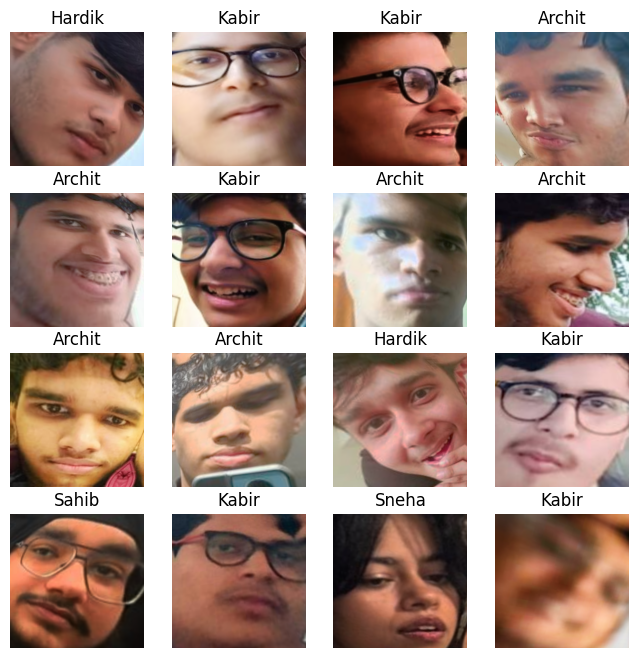

In [16]:
friends = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(299),   # larger input size for more detail
    batch_tfms=[
        *aug_transforms(
            mult=1.0, do_flip=True, flip_vert=False,
            max_rotate=15, max_zoom=1.2,
            max_lighting=0.3, max_warp=0.3,
            p_affine=0.9, p_lighting=0.9
        ),
        Normalize.from_stats(*imagenet_stats)  # normalize to ImageNet mean/std
    ]
)

dls = friends.dataloaders(data_path, bs=32)
dls.show_batch(max_n=16, figsize=(8,8))

### Step 3: Model Definition
- Use a pretrained ResNet backbone (resnet34)
- Attach a classification head for 5 classes
- Track accuracy during training

In [17]:
# Create a learner with a ResNet backbone
learn = vision_learner(
    dls, resnet34, metrics=[accuracy, error_rate])
# Peek at the model architecture
learn.model


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
# Fine-tune for 4 epochs
learn.fine_tune(7, cbs=SaveModelCallback(monitor='accuracy'))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.172100,1.110178,0.556701,0.443299,00:01


Better model found at epoch 0 with accuracy value: 0.5567010045051575.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.072829,0.919023,0.670103,0.329897,00:02
1,0.897170,0.675361,0.824742,0.175258,00:02
2,0.703016,0.576341,0.855670,0.144330,00:02
3,0.596707,0.325189,0.907216,0.092784,00:02
4,0.483171,0.311929,0.917526,0.082474,00:02
5,0.384682,0.289924,0.917526,0.082474,00:02
6,0.337023,0.267766,0.917526,0.082474,00:02


Better model found at epoch 0 with accuracy value: 0.6701030731201172.
Better model found at epoch 1 with accuracy value: 0.8247422575950623.
Better model found at epoch 2 with accuracy value: 0.8556700944900513.
Better model found at epoch 3 with accuracy value: 0.907216489315033.
Better model found at epoch 4 with accuracy value: 0.9175257682800293.


### Step 5: Evaluation
- Generate a **confusion matrix** to see which friends are being confused with each other.
- Inspect **top losses** (the hardest misclassified images).
- Optionally, view a **per-class accuracy breakdown** to check if some friends are harder to classify.

              precision    recall  f1-score   support

      Archit       0.93      0.91      0.92        44
      Hardik       0.88      0.88      0.88        16
       Kabir       0.92      1.00      0.96        11
       Sahib       0.91      0.91      0.91        11
       Sneha       0.93      0.93      0.93        15

    accuracy                           0.92        97
   macro avg       0.91      0.93      0.92        97
weighted avg       0.92      0.92      0.92        97



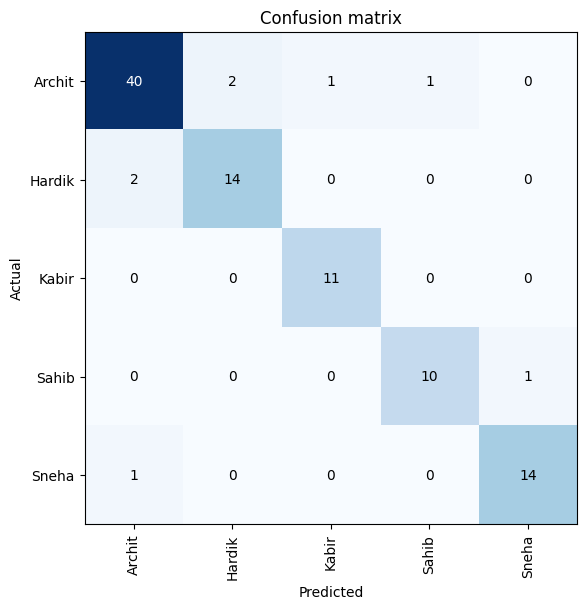

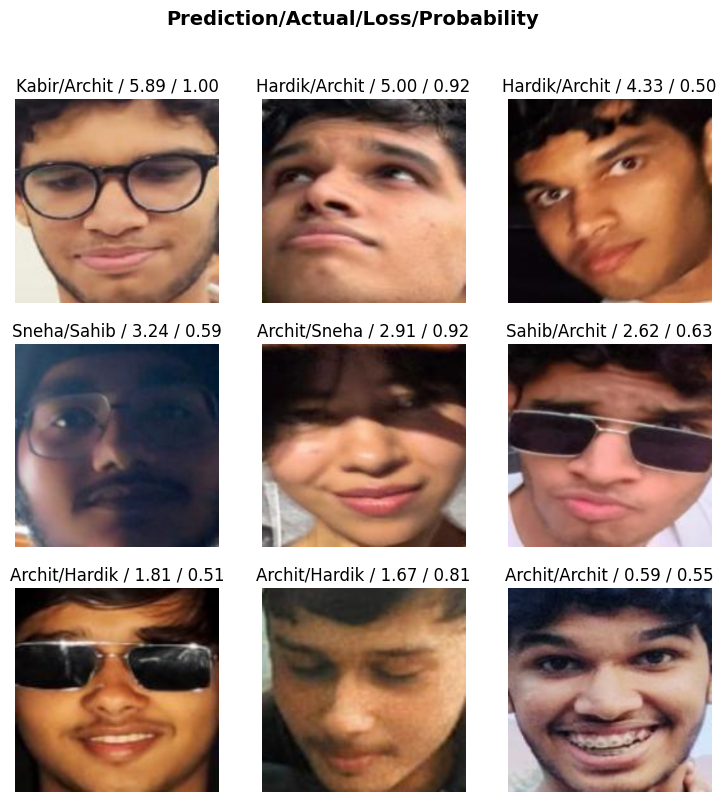

In [19]:
# Create interpretation object
interp = ClassificationInterpretation.from_learner(learn)

# 1. Confusion Matrix
interp.plot_confusion_matrix(figsize=(6,6))

# 2. Top Losses (hardest mistakes)
interp.plot_top_losses(9, nrows=3)

# 3. Per-class accuracy
interp.print_classification_report()

### Step 6: Export the Trained Model
- Save the trained model as a `.pkl` file for later use.
- Reload it with `load_learner` to confirm it works.
- This file will be used in Phase 3 (Gradio app deployment).

In [22]:
# Export the trained model
learn.export('friends_classifier.pkl')

# Reload the model to test
learn_inf = load_learner('friends_classifier.pkl')

# Quick test prediction
img = PILImage.create(r"C:\Users\Archit\Desktop\Frendclassifier\Images\Clustered\Archit\sample.jpg")
pred_class, pred_idx, probs = learn_inf.predict(img)
print(f"Prediction: {pred_class}, Probability: {probs[pred_idx]:.4f}")

C:\Users\Archit\anaconda3\envs\fc\lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Prediction: Archit, Probability: 0.9996
